## Problem Statement

The number of reported results vary daily. Develop a model to explain this variation and use your model to create a prediction interval for the number of reported results on March 1, 2023. Do any attributes of the word affect the percentage of scores reported that were played in Hard Mode? If so, how? If not, why not?

In [121]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pmdarima.arima as arima
dataset = pd.read_excel("./dataset/wordle_data.xlsx", index_col=0, usecols="A,D")

### Read the Data

Note that from the structure of the data, we can see that Wordle became very famous soon it was first released, so there was a peak at the very beginning, but after that is falls to a relatively stable descending state with small perturbations. Therefore, we only take the last five months of data which are after that peak, so as to avoid overfitting that part.

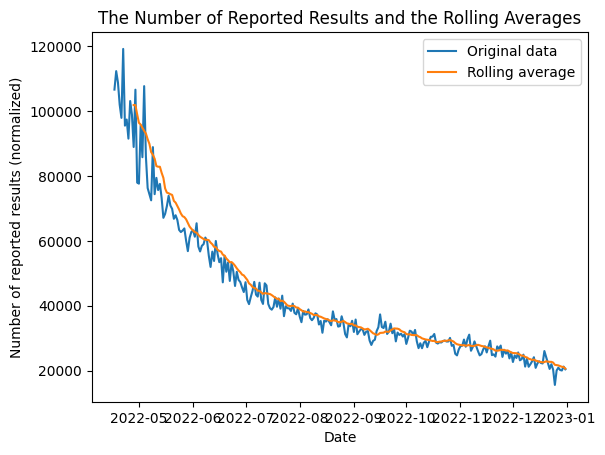

In [122]:
df = dataset.sort_index()[100:]
rol_av = df.rolling(window=12).mean()
plt.plot(df, label="Original data")
plt.plot(rol_av, label="Rolling average")
plt.xlabel("Date")
plt.ylabel("Number of reported results (normalized)")
plt.title("The Number of Reported Results and the Rolling Averages")
plt.legend()
plt.show()

### Rescale (Normalize) Data to $[0,1]$

In [123]:
orimin, orimax = df["result_num"].min(), df["result_num"].max()
df["result_num"] -= orimin
df["result_num"] /= (orimax - orimin)

## Autoregressive Integrated Moving Average (ARIMA)

The ARIMA model is used for predicting the future based on a time series in the past. It examines serial correlation, which is an implication of how future data is correlated with past data (across a certain period of time).

### Train the Model and Test the Result

Mean squared error = 0.1110


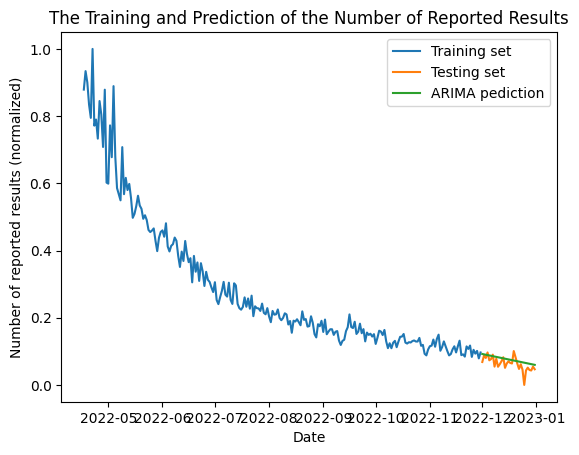

In [124]:
split_date = pd.to_datetime("2022-12-1", format="%Y-%m-%d")
train, test = df.loc[df.index < split_date], df.loc[df.index >= split_date]
ARIMA = arima.auto_arima(train)
ARIMA.fit(train)
prediction = pd.DataFrame(ARIMA.predict(n_periods=len(test)), index=test.index, columns=test.columns)
err = np.linalg.norm(test["result_num"] - prediction["result_num"])
print("Mean squared error = {:.4f}".format(err))
plt.plot(train, label="Training set")
plt.plot(test, label="Testing set")
plt.plot(prediction, label="ARIMA pediction")
plt.xlabel("Date")
plt.ylabel("Number of reported results (normalized)")
plt.title("The Training and Prediction of the Number of Reported Results")
plt.legend()
plt.show()

### Prediction for March 1st

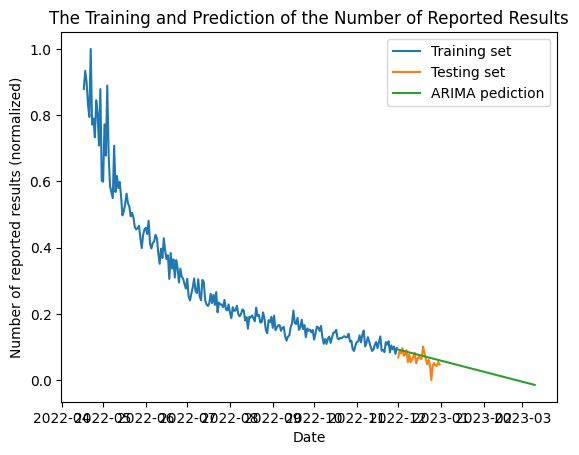

In [125]:
pred_days = 100
pred_dates = [test.index[0] + datetime.timedelta(days=x) for x in range(pred_days)]
prediction = pd.DataFrame(ARIMA.predict(n_periods=pred_days), index=pred_dates, columns=test.columns)
plt.plot(train, label="Training set")
plt.plot(test, label="Testing set")
plt.plot(prediction, label="ARIMA pediction")
plt.xlabel("Date")
plt.ylabel("Number of reported results (normalized)")
plt.title("The Training and Prediction of the Number of Reported Results")
plt.legend()
plt.show()

In [126]:
target_date = pd.to_datetime("2023-03-01", format="%Y-%m-%d")
print("Result:", int(prediction.loc[target_date] * (orimax - orimin) + orimin))

Result: 15040


## Fitting with $f(x)=a(x+b)^{-0.25}+c$

### Train the Model and Test the Result

In [144]:
date_indices = np.array(range(df.size))
report_nums = df["result_num"].to_numpy()
exp_func = lambda x, a, b, c: a * (x + b) ** (-0.25) + c
params, _ = curve_fit(exp_func, date_indices[:-31], report_nums[:-31])
exp_fit_train = exp_func(date_indices[:-31], *params)
exp_fit_test = exp_func(date_indices[-31:], *params)
err = np.linalg.norm(report_nums[-31:] - exp_fit_test)
print("Mean squared error: {:.4f}".format(err))

Mean squared error: 0.0912


### Prediction for March 1st

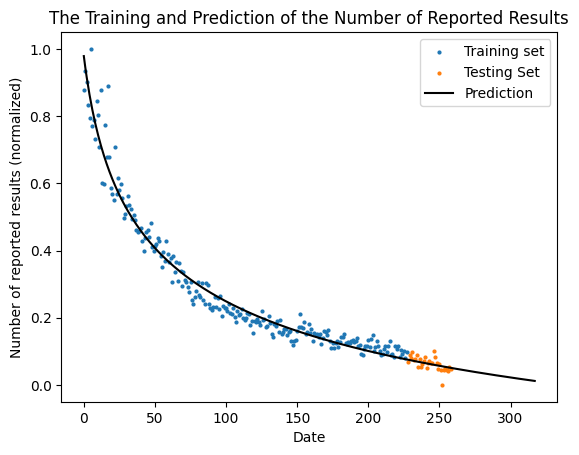

Result: 16786


In [143]:
target = 318
pred_indices = np.array(range(target))
prediction = exp_func(pred_indices, *params)
plt.scatter(date_indices[:-31], report_nums[:-31], s=4, label="Training set")
plt.scatter(date_indices[-31:], report_nums[-31:], s=4, label="Testing Set")
plt.plot(pred_indices, prediction, label="Prediction", color="black")
plt.xlabel("Date")
plt.ylabel("Number of reported results (normalized)")
plt.title("The Training and Prediction of the Number of Reported Results")
plt.legend()
plt.show()
print("Result:", int(prediction[-1] * (orimax - orimin) + orimin))